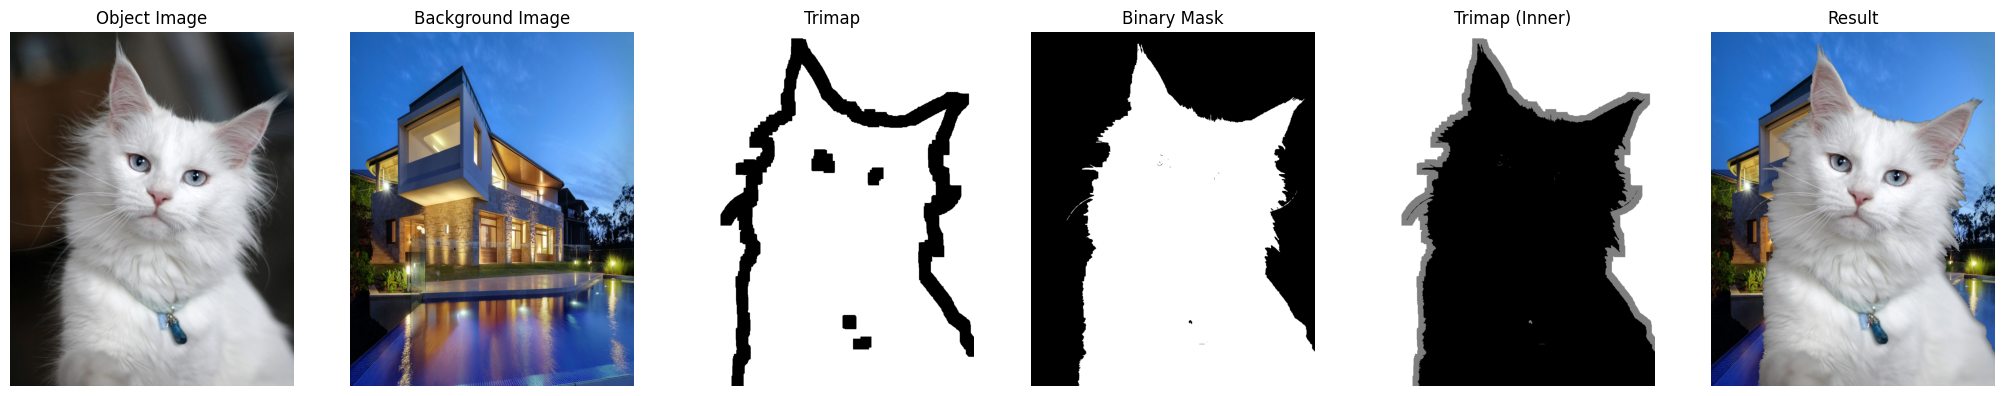

In [52]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def image_matting(object_image_path, background_image_path):
    # Read the object image
    object_image = cv2.imread(object_image_path)
    object_image = cv2.cvtColor(object_image, cv2.COLOR_BGR2RGB)

    # Create an initial mask for GrabCut
    mask = np.zeros(object_image.shape[:2], np.uint8)

    # Define the rectangle for GrabCut
    rect = (10, 10, object_image.shape[1]-10, object_image.shape[0]-10)

    # Allocate memory for models needed by GrabCut
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)

    # Apply GrabCut
    cv2.grabCut(object_image, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

    # Convert the mask to binary
    binary_mask = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8') * 255

    # Create trimap by dilating and then eroding the binary mask
    kernel = np.ones((5, 5), np.uint8)
    dilated = cv2.dilate(binary_mask, kernel, iterations=10)
    eroded = cv2.erode(binary_mask, kernel, iterations=10)
    trimap = np.where((dilated == 255) & (eroded == 0), 127, 255).astype(np.uint8)

    # Ensure absolute values inside object area in inner trimap layer
    trimap_inner = trimap.copy()
    trimap_inner[binary_mask == 255] = 0  # Set to 0 where object is present

    # Read the background image
    background_image = cv2.imread(background_image_path)
    background_image = cv2.cvtColor(background_image, cv2.COLOR_BGR2RGB)

    # Resize the background image to match the object image size
    background_image = cv2.resize(background_image, (object_image.shape[1], object_image.shape[0]))

    # Composite object image and background image using alpha matte
    alpha_matte = binary_mask.astype(np.float32) / 255.0
    result_image = np.zeros_like(object_image, dtype=np.uint8)
    for i in range(3):
        result_image[:,:,i] = alpha_matte * object_image[:,:,i] + (1 - alpha_matte) * background_image[:,:,i]

    return object_image, background_image, result_image, binary_mask, trimap, trimap_inner

def plot_images(object_image, background_image, result_image, binary_mask, trimap, trimap_inner):
    plt.figure(figsize=(30, 8))

    # Object image
    plt.subplot(1, 7, 1)
    plt.imshow(object_image)
    plt.title('Object Image')
    plt.axis('off')

    # Background image
    plt.subplot(1, 7, 2)
    plt.imshow(background_image)
    plt.title('Background Image')
    plt.axis('off')

    # Binary mask
    plt.subplot(1, 7, 4)
    plt.imshow(binary_mask, cmap='gray')
    plt.title('Binary Mask')
    plt.axis('off')

    # Trimap
    plt.subplot(1, 7, 3)
    plt.imshow(trimap, cmap='gray')
    plt.title('Trimap')
    plt.axis('off')

    # Trimap Inner
    plt.subplot(1, 7, 5)
    plt.imshow(trimap_inner, cmap='gray')
    plt.title('Trimap (Inner)')
    plt.axis('off')

    # Result image
    plt.subplot(1, 7, 6)
    plt.imshow(result_image)
    plt.title('Result')
    plt.axis('off')

    plt.show()

object_image_path = 'cat2.jpg'  # Replace with your object image file path
background_image_path = 'house.jpg'  # Replace with your background image file path

object_image, background_image, result_image, binary_mask, trimap, trimap_inner = image_matting(object_image_path, background_image_path)
plot_images(object_image, background_image, result_image, binary_mask, trimap, trimap_inner)


C:\Users\Asus\AppData\Local\Temp\ipykernel_27820\3259258135.py:20: UserWarning: Image values should be in [0, 1], but image.max() is 255.
  alpha_matte = estimate_alpha_knn(object_image, trimap)
C:\Users\Asus\AppData\Local\Temp\ipykernel_27820\3259258135.py:20: UserWarning: Unexpected image.dtype uint8. Are you sure that you do not want to use np.float32 or np.float64 instead?
  alpha_matte = estimate_alpha_knn(object_image, trimap)


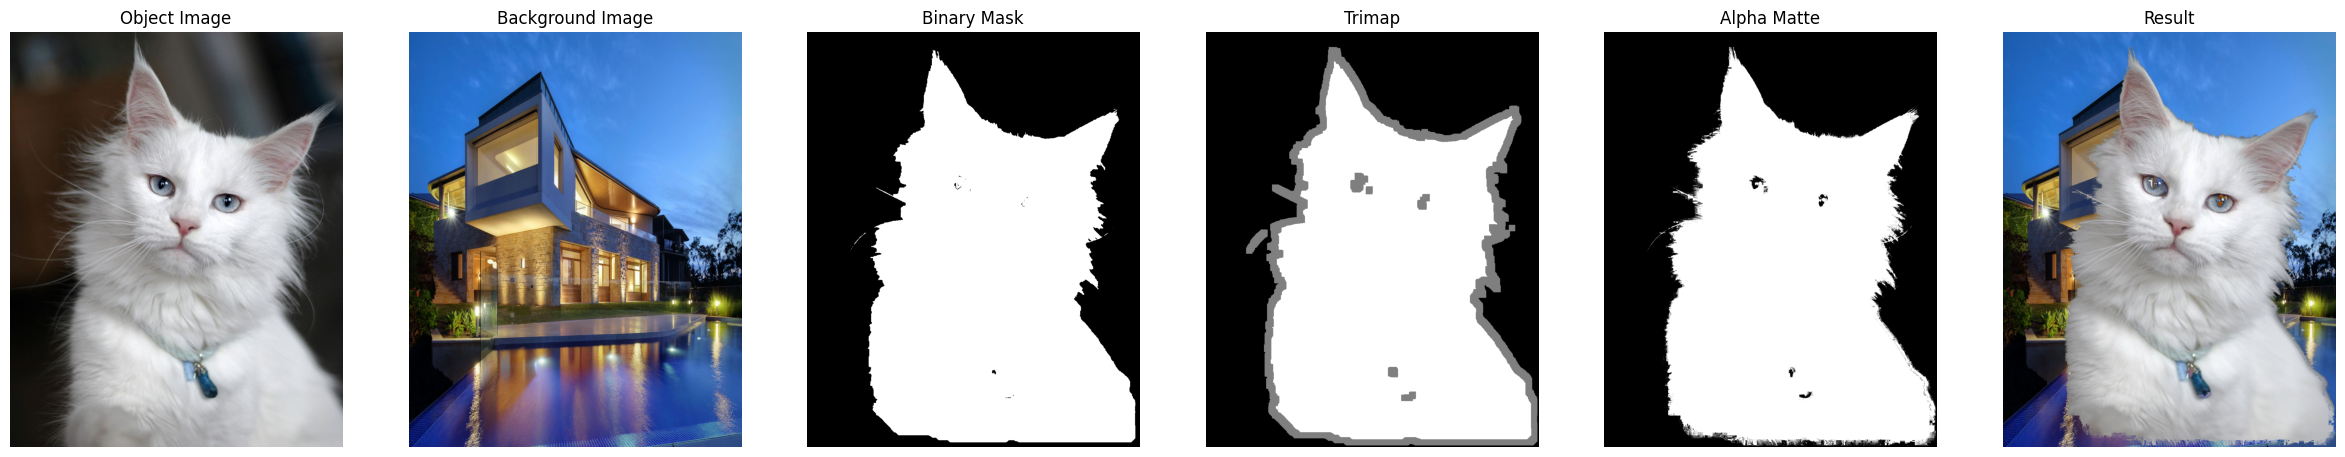

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pymatting import estimate_alpha_knn

def create_trimap(binary_mask):
    # Adjust the kernel size and the number of iterations for better results
    kernel = np.ones((5, 5), np.uint8)
    dilated = cv2.dilate(binary_mask, kernel, iterations=5)
    eroded = cv2.erode(binary_mask, kernel, iterations=5)
    
    trimap = np.full(binary_mask.shape, 127, np.uint8)
    trimap[eroded == 255] = 255  # Definite foreground
    trimap[dilated == 0] = 0     # Definite background
    return trimap

def knn_matting(object_image, trimap):
    # KNN Matting
    trimap = trimap.astype(np.float32) / 255.0
    alpha_matte = estimate_alpha_knn(object_image, trimap)
    return alpha_matte

def image_matting(object_image_path, background_image_path):
    # Read the object image
    object_image = cv2.imread(object_image_path)
    object_image = cv2.cvtColor(object_image, cv2.COLOR_BGR2RGB)

    # Create an initial mask for GrabCut
    mask = np.zeros(object_image.shape[:2], np.uint8)

    # Define the rectangle for GrabCut
    rect = (15, 15, object_image.shape[1] - 30, object_image.shape[0] - 30)  # Adjusted for better accuracy

    # Allocate memory for models needed by GrabCut
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)

    # Apply GrabCut with more iterations for better results
    cv2.grabCut(object_image, mask, rect, bgdModel, fgdModel, 7, cv2.GC_INIT_WITH_RECT)

    # Refine mask: reassign pixels as probable foreground or background
    mask[(mask == 2) | (mask == 0)] = 0
    mask[(mask == 1) | (mask == 3)] = 1

    # Convert the mask to binary
    binary_mask = mask * 255

    # Create trimap
    trimap = create_trimap(binary_mask)

    # Apply KNN Matting
    alpha_matte = knn_matting(object_image, trimap)

    # Read the background image
    background_image = cv2.imread(background_image_path)
    background_image = cv2.cvtColor(background_image, cv2.COLOR_BGR2RGB)

    # Resize the background image to match the object image size
    background_image = cv2.resize(background_image, (object_image.shape[1], object_image.shape[0]))

    # Composite object image and background image using alpha matte
    result_image = np.zeros_like(object_image, dtype=np.uint8)
    for i in range(3):
        result_image[:, :, i] = (alpha_matte * object_image[:, :, i] + (1 - alpha_matte) * background_image[:, :, i]).astype(np.uint8)

    return object_image, background_image, result_image, binary_mask, trimap, alpha_matte

def plot_images(object_image, background_image, result_image, binary_mask, trimap, alpha_matte):
    plt.figure(figsize=(30, 8))

    # Object image
    plt.subplot(1, 6, 1)
    plt.imshow(object_image)
    plt.title('Object Image')
    plt.axis('off')

    # Background image
    plt.subplot(1, 6, 2)
    plt.imshow(background_image)
    plt.title('Background Image')
    plt.axis('off')

    # Binary mask
    plt.subplot(1, 6, 3)
    plt.imshow(binary_mask, cmap='gray')
    plt.title('Binary Mask')
    plt.axis('off')

    # Trimap
    plt.subplot(1, 6, 4)
    plt.imshow(trimap, cmap='gray')
    plt.title('Trimap')
    plt.axis('off')

    # Alpha Matte
    plt.subplot(1, 6, 5)
    plt.imshow(alpha_matte, cmap='gray')
    plt.title('Alpha Matte')
    plt.axis('off')

    # Result image
    plt.subplot(1, 6, 6)
    plt.imshow(result_image)
    plt.title('Result')
    plt.axis('off')

    plt.show()

object_image_path = 'cat2.jpg'  # Replace with your object image file path
background_image_path = 'house.jpg'  # Replace with your background image file path

object_image, background_image, result_image, binary_mask, trimap, alpha_matte = image_matting(object_image_path, background_image_path)
plot_images(object_image, background_image, result_image, binary_mask, trimap, alpha_matte)


C:\Users\Asus\AppData\Local\Temp\ipykernel_27820\3282686356.py:20: UserWarning: Image values should be in [0, 1], but image.max() is 255.
  alpha_matte = estimate_alpha_knn(object_image, trimap)
C:\Users\Asus\AppData\Local\Temp\ipykernel_27820\3282686356.py:20: UserWarning: Unexpected image.dtype uint8. Are you sure that you do not want to use np.float32 or np.float64 instead?
  alpha_matte = estimate_alpha_knn(object_image, trimap)


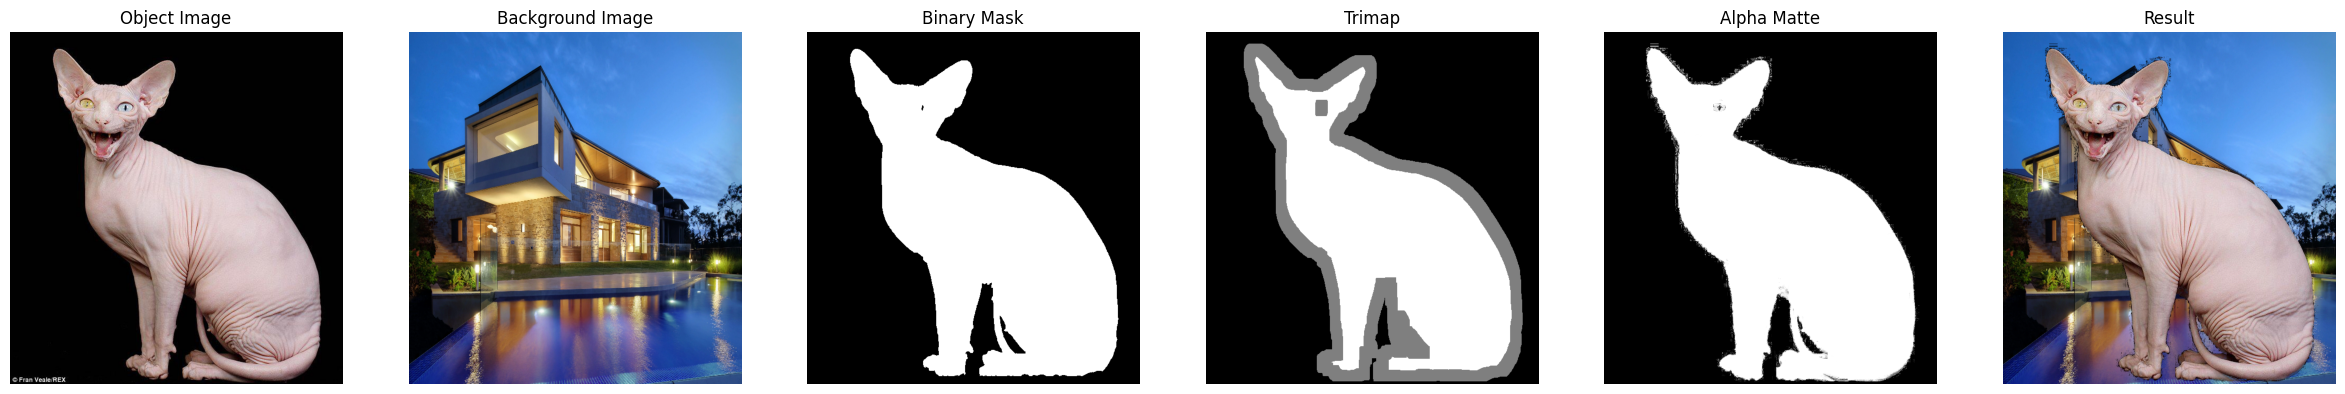

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pymatting import estimate_alpha_knn

def create_trimap(binary_mask):
    # Adjust the kernel size and the number of iterations for better results
    kernel = np.ones((5, 5), np.uint8)
    dilated = cv2.dilate(binary_mask, kernel, iterations=5)
    eroded = cv2.erode(binary_mask, kernel, iterations=5)
    
    trimap = np.full(binary_mask.shape, 127, np.uint8)
    trimap[eroded == 255] = 255  # Definite foreground
    trimap[dilated == 0] = 0     # Definite background
    return trimap

def knn_matting(object_image, trimap):
    # KNN Matting
    trimap = trimap.astype(np.float32) / 255.0
    alpha_matte = estimate_alpha_knn(object_image, trimap)
    return alpha_matte

def image_matting(object_image_path, background_image_path):
    # Read the object image
    object_image = cv2.imread(object_image_path)
    object_image = cv2.cvtColor(object_image, cv2.COLOR_BGR2RGB)

    # Create an initial mask for GrabCut
    mask = np.zeros(object_image.shape[:2], np.uint8)

    # Define the rectangle for GrabCut
    rect = (15, 15, object_image.shape[1] - 30, object_image.shape[0] - 30)  # Adjusted for better accuracy

    # Allocate memory for models needed by GrabCut
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)

    # Apply GrabCut with more iterations for better results
    cv2.grabCut(object_image, mask, rect, bgdModel, fgdModel, 7, cv2.GC_INIT_WITH_RECT)

    # Refine mask: reassign pixels as probable foreground or background
    mask[(mask == 2) | (mask == 0)] = 0
    mask[(mask == 1) | (mask == 3)] = 1

    # Convert the mask to binary
    binary_mask = mask * 255

    # Create trimap
    trimap = create_trimap(binary_mask)

    # Apply KNN Matting
    alpha_matte = knn_matting(object_image, trimap)

    # Read the background image
    background_image = cv2.imread(background_image_path)
    background_image = cv2.cvtColor(background_image, cv2.COLOR_BGR2RGB)

    # Resize the background image to match the object image size
    background_image = cv2.resize(background_image, (object_image.shape[1], object_image.shape[0]))

    # Composite object image and background image using alpha matte
    result_image = np.zeros_like(object_image, dtype=np.uint8)
    for i in range(3):
        result_image[:, :, i] = (alpha_matte * object_image[:, :, i] + (1 - alpha_matte) * background_image[:, :, i]).astype(np.uint8)

    return object_image, background_image, result_image, binary_mask, trimap, alpha_matte

def plot_images(object_image, background_image, result_image, binary_mask, trimap, alpha_matte):
    plt.figure(figsize=(30, 8))

    # Object image
    plt.subplot(1, 6, 1)
    plt.imshow(object_image)
    plt.title('Object Image')
    plt.axis('off')

    # Background image
    plt.subplot(1, 6, 2)
    plt.imshow(background_image)
    plt.title('Background Image')
    plt.axis('off')

    # Binary mask
    plt.subplot(1, 6, 3)
    plt.imshow(binary_mask, cmap='gray')
    plt.title('Binary Mask')
    plt.axis('off')

    # Trimap
    plt.subplot(1, 6, 4)
    plt.imshow(trimap, cmap='gray')
    plt.title('Trimap')
    plt.axis('off')

    # Alpha Matte
    plt.subplot(1, 6, 5)
    plt.imshow(alpha_matte, cmap='gray')
    plt.title('Alpha Matte')
    plt.axis('off')

    # Result image
    plt.subplot(1, 6, 6)
    plt.imshow(result_image)
    plt.title('Result')
    plt.axis('off')

    plt.show()

object_image_path = 'furless3.jpg'  # Replace with your object image file path
background_image_path = 'house.jpg'  # Replace with your background image file path

object_image, background_image, result_image, binary_mask, trimap, alpha_matte = image_matting(object_image_path, background_image_path)
plot_images(object_image, background_image, result_image, binary_mask, trimap, alpha_matte)


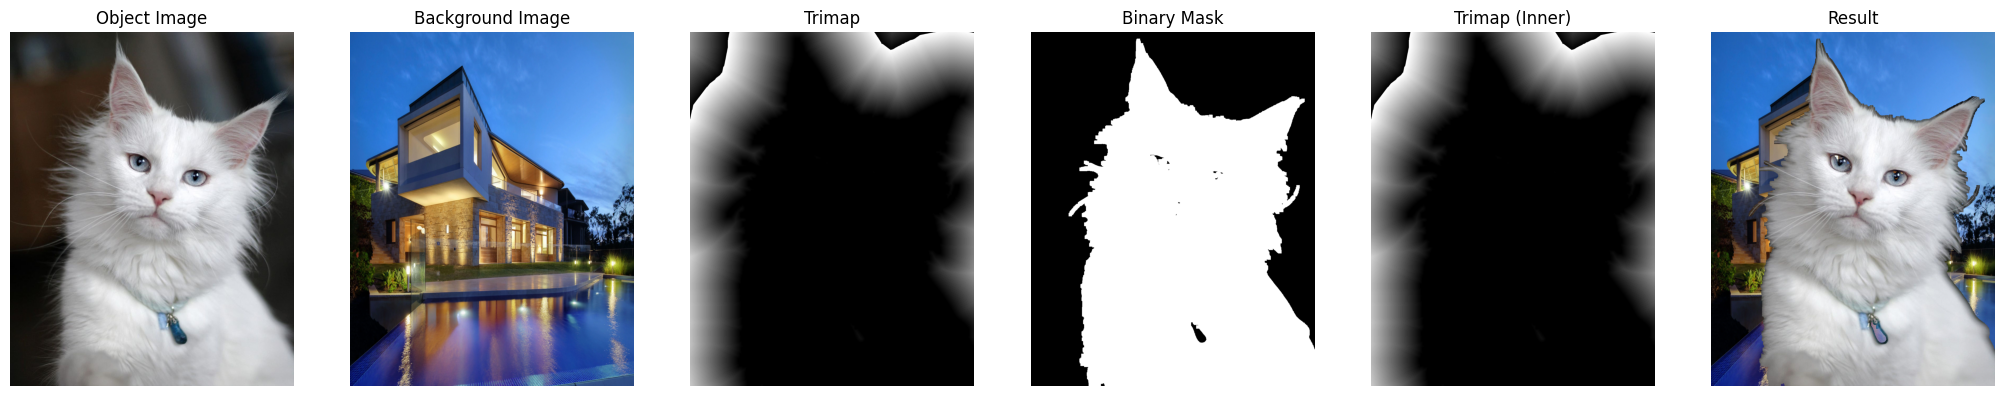

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def image_matting(object_image_path, background_image_path):
  # Read the object image
  object_image = cv2.imread(object_image_path)
  object_image = cv2.cvtColor(object_image, cv2.COLOR_BGR2RGB)

  # Convert object image to grayscale
  gray_image = cv2.cvtColor(object_image, cv2.COLOR_RGB2GRAY)

  # Thresholding to obtain binary mask (Can be adjusted for better foreground extraction)
  _, binary_mask = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

  # Manual adjustments for eyes and collar (Replace with user interaction or better segmentation)
  # Increase brush size and adjust mask values (0-background, 255-foreground) for better results
  kernel = np.ones((5, 5), np.uint8)
  # Modify these regions based on your image to include the cat's eyes and collar in the foreground
  eyes_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel, iterations=2)  # Close operation to fill small holes
  collar_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_DILATE, kernel, iterations=3)  # Dilate to include collar area

  # Combine masks to ensure eyes and collar are foreground
  binary_mask = cv2.bitwise_or(binary_mask, eyes_mask)
  binary_mask = cv2.bitwise_or(binary_mask, collar_mask)

  # Create trimap by dilating and then eroding the binary mask
#   trimap = cv2.distanceTransform(255 - binary_mask, cv2.DIST_C_MASK, 5).astype(np.uint8)
  trimap = cv2.distanceTransform(255 - binary_mask, cv2.DIST_L2, 5).astype(np.uint8)

  # Adjust distance transform parameter for better trimap generation

  # Ensure absolute values inside object area in inner trimap layer
  trimap_inner = trimap.copy()
  trimap_inner[binary_mask == 255] = 0  # Set to 0 where object is present

  # Read the background image
  background_image = cv2.imread(background_image_path)
  background_image = cv2.cvtColor(background_image, cv2.COLOR_BGR2RGB)

  # Resize the background image to match the object image size
  background_image = cv2.resize(background_image, (object_image.shape[1], object_image.shape[0]))

  # Composite object image and background image using alpha matte
  alpha_matte = binary_mask.astype(np.float32) / 255.0
  result_image = np.zeros_like(object_image, dtype=np.uint8)
  for i in range(3):
    result_image[:, :, i] = alpha_matte * object_image[:, :, i] + (1 - alpha_matte) * background_image[:, :, i]

  return object_image, background_image, result_image, binary_mask, trimap, trimap_inner

def plot_images(object_image, background_image, result_image, binary_mask, trimap, trimap_inner):
  plt.figure(figsize=(30, 8))

  # Object image
  plt.subplot(1, 7, 1)
  plt.imshow(object_image)
  plt.title('Object Image')
  plt.axis('off')

  # Background image
  plt.subplot(1, 7, 2)
  plt.imshow(background_image)
  plt.title('Background Image')
  plt.axis('off')

  # Binary mask
  plt.subplot(1, 7, 4)
  plt.imshow(binary_mask, cmap='gray')
  plt.title('Binary Mask')
  plt.axis('off')

  # Trimap
  plt.subplot(1, 7, 3)
  plt.imshow(trimap, cmap='gray')
  plt.title('Trimap')
  plt.axis('off')

  # Trimap Inner
  plt.subplot
  plt.subplot(1, 7, 5)
  plt.imshow(trimap_inner, cmap='gray')
  plt.title('Trimap (Inner)')
  plt.axis('off')

  # Result image
  plt.subplot(1, 7, 6)
  plt.imshow(result_image)
  plt.title('Result')
  plt.axis('off')

  plt.show()

object_image_path = 'cat2.jpg'  # Replace with your object image file path
background_image_path = 'house.jpg'  # Replace with your background image file path

object_image, background_image, result_image, binary_mask, trimap, trimap_inner = image_matting(object_image_path, background_image_path)
plot_images(object_image, background_image, result_image, binary_mask, trimap, trimap_inner)


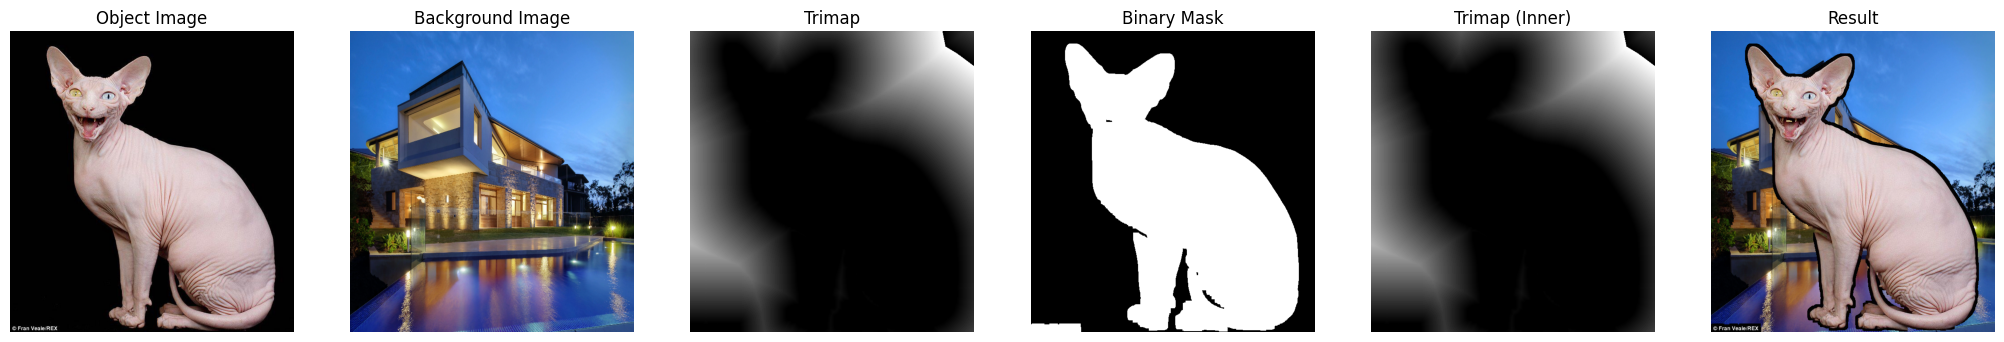

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def image_matting(object_image_path, background_image_path):
  # Read the object image
  object_image = cv2.imread(object_image_path)
  object_image = cv2.cvtColor(object_image, cv2.COLOR_BGR2RGB)

  # Convert object image to grayscale
  gray_image = cv2.cvtColor(object_image, cv2.COLOR_RGB2GRAY)

  # Thresholding to obtain binary mask (Can be adjusted for better foreground extraction)
  _, binary_mask = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

  # Manual adjustments for eyes and collar (Replace with user interaction or better segmentation)
  # Increase brush size and adjust mask values (0-background, 255-foreground) for better results
  kernel = np.ones((5, 5), np.uint8)
  # Modify these regions based on your image to include the cat's eyes and collar in the foreground
  eyes_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel, iterations=2)  # Close operation to fill small holes
  collar_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_DILATE, kernel, iterations=3)  # Dilate to include collar area

  # Combine masks to ensure eyes and collar are foreground
  binary_mask = cv2.bitwise_or(binary_mask, eyes_mask)
  binary_mask = cv2.bitwise_or(binary_mask, collar_mask)

  # Create trimap by dilating and then eroding the binary mask
#   trimap = cv2.distanceTransform(255 - binary_mask, cv2.DIST_C_MASK, 5).astype(np.uint8)
  trimap = cv2.distanceTransform(255 - binary_mask, cv2.DIST_L2, 5).astype(np.uint8)

  # Adjust distance transform parameter for better trimap generation

  # Ensure absolute values inside object area in inner trimap layer
  trimap_inner = trimap.copy()
  trimap_inner[binary_mask == 255] = 0  # Set to 0 where object is present

  # Read the background image
  background_image = cv2.imread(background_image_path)
  background_image = cv2.cvtColor(background_image, cv2.COLOR_BGR2RGB)

  # Resize the background image to match the object image size
  background_image = cv2.resize(background_image, (object_image.shape[1], object_image.shape[0]))

  # Composite object image and background image using alpha matte
  alpha_matte = binary_mask.astype(np.float32) / 255.0
  result_image = np.zeros_like(object_image, dtype=np.uint8)
  for i in range(3):
    result_image[:, :, i] = alpha_matte * object_image[:, :, i] + (1 - alpha_matte) * background_image[:, :, i]

  return object_image, background_image, result_image, binary_mask, trimap, trimap_inner

def plot_images(object_image, background_image, result_image, binary_mask, trimap, trimap_inner):
  plt.figure(figsize=(30, 8))

  # Object image
  plt.subplot(1, 7, 1)
  plt.imshow(object_image)
  plt.title('Object Image')
  plt.axis('off')

  # Background image
  plt.subplot(1, 7, 2)
  plt.imshow(background_image)
  plt.title('Background Image')
  plt.axis('off')

  # Binary mask
  plt.subplot(1, 7, 4)
  plt.imshow(binary_mask, cmap='gray')
  plt.title('Binary Mask')
  plt.axis('off')

  # Trimap
  plt.subplot(1, 7, 3)
  plt.imshow(trimap, cmap='gray')
  plt.title('Trimap')
  plt.axis('off')

  # Trimap Inner
  plt.subplot
  plt.subplot(1, 7, 5)
  plt.imshow(trimap_inner, cmap='gray')
  plt.title('Trimap (Inner)')
  plt.axis('off')

  # Result image
  plt.subplot(1, 7, 6)
  plt.imshow(result_image)
  plt.title('Result')
  plt.axis('off')

  plt.show()

object_image_path = 'furless3.jpg'  # Replace with your object image file path
background_image_path = 'house.jpg'  # Replace with your background image file path

object_image, background_image, result_image, binary_mask, trimap, trimap_inner = image_matting(object_image_path, background_image_path)
plot_images(object_image, background_image, result_image, binary_mask, trimap, trimap_inner)
